# Visualizing raster data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Raster-visualization-basics" data-toc-modified-id="Raster-visualization-basics-1">Raster visualization basics</a></span><ul class="toc-item"><li><span><a href="#Searching-for-imagery-layer-items" data-toc-modified-id="Searching-for-imagery-layer-items-1.1">Searching for imagery layer items</a></span></li><li><span><a href="#Adding-imagery-layer-onto-a-map" data-toc-modified-id="Adding-imagery-layer-onto-a-map-1.2">Adding imagery layer onto a map</a></span></li></ul></li><li><span><a href="#Raster-functions-(on-the-fly)" data-toc-modified-id="Raster-functions-(on-the-fly)-2">Raster functions (on-the-fly)</a></span><ul class="toc-item"><li><span><a href="#Using-raster-functions-associated-with-imagery-layer" data-toc-modified-id="Using-raster-functions-associated-with-imagery-layer-2.1">Using raster functions associated with imagery layer</a></span></li><li><span><a href="#Using-built-in-raster-functions-in-Python-API" data-toc-modified-id="Using-built-in-raster-functions-in-Python-API-2.2">Using built-in raster functions in Python API</a></span></li><li><span><a href="#Compute-NDVI-through-map-algebra" data-toc-modified-id="Compute-NDVI-through-map-algebra-2.3">Compute NDVI through map algebra</a></span></li><li><span><a href="#Chaining-raster-functions" data-toc-modified-id="Chaining-raster-functions-2.4">Chaining raster functions</a></span></li><li><span><a href="#Visualize-the-workflow-using-draw_graph" data-toc-modified-id="Visualize-the-workflow-using-draw_graph-2.5">Visualize the workflow using <code>draw_graph</code></a></span></li><li><span><a href="#Saving-your-results" data-toc-modified-id="Saving-your-results-2.6">Saving your results</a></span></li></ul></li></ul></div>

## Raster visualization basics

### Searching for imagery layer items

You can search the GIS for imagery layers by specifying the item type as `Imagery Layer`:

In [1]:
import arcgis
from arcgis.gis import GIS
from IPython.display import display

# gis = GIS() # can be online/enterprise
gis = GIS("https://pythonapi.playground.esri.com/portal", "arcgis_python", "amazing_arcgis_123")

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
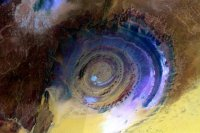

<Item title:"Landsat GLS Multispectral" type:Imagery Layer owner:esri_livingatlas>
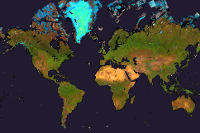

In [3]:
items = gis.content.search("title: Multispectral Landsat", item_type="Imagery Layer")

for i in range(2):
    display(items[i])

Convert item to `ImageryLayer` object.

In [4]:
l8_lyr = items[0].layers[0]
type(l8_lyr)

arcgis.raster._layer.ImageryLayer

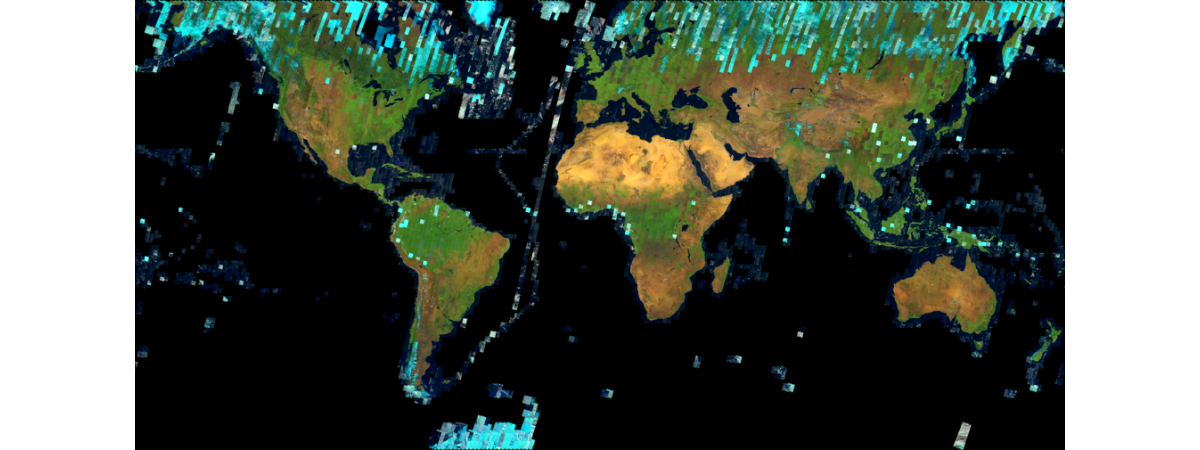

In [5]:
l8_lyr  # get the a screenshot for you to quickly look at how it looks

### Adding imagery layer onto a map

In [6]:
l8_map = gis.map('Redlands, CA') # create a map with its center at Redlands
l8_map

MapView(layout=Layout(height='400px', width='100%'))

In [7]:
l8_map.add_layer(l8_lyr) # you can zoom in to any extent of your choice

## Raster functions (on-the-fly)

Essentially algorithms you'd like to apply to your raster data. It can be as simple as band extraction or you can even do advanced analysis like deep learning with it.

### Using raster functions associated with imagery layer
Two types of raster functions. The 1st type is the raster functions published with your data. In order words, when you publish your raster data, you can also choose to publish algorihtm with it.

In [8]:
for fn in l8_lyr.properties.rasterFunctionInfos: # what raster functions l8_lyr has
    print(fn['name'])

Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Natural Color with DRA
Short-wave Infrared with DRA
Geology with DRA
Agriculture
Bathymetric
Color Infrared
Geology
Natural Color
Short-wave Infrared
NDVI Colorized
Normalized Difference Moisture Index Colorized
NDVI Raw
NBR Raw
None


Let's try applying the "[color infrared](https://eos.com/color-infrared/)" raster function, which is a commanly used band combination to highlight vegetation.

In [9]:
infrared_map = gis.map('Redlands, CA')
infrared_map

MapView(layout=Layout(height='400px', width='100%'))

In [10]:
from arcgis.raster.functions import apply

infrared_lr = apply(l8_lyr, "Color Infrared") # on-the-fly
infrared_map.add_layer(infrared_lr)

It's worth noting that raster functions are only applied to the screen extent(at display resolution). Whenever you change the extent of the map widget, raster function will be applied to those uncovered area on-the-fly. It saves lot of unnecessary computation and it's super performant in this sense.

### Using built-in raster functions in Python API
The 2nd type of raster function. For instance, if you want to create a NDVI image, you can just call `ndvi()` directly. NDVI = ((NIR - Red)/(NIR + Red))

In [11]:
ndvi_map = gis.map('Redlands, CA')
ndvi_map

MapView(layout=Layout(height='400px', width='100%'))

In [12]:
from arcgis.raster.functions import ndvi

ndvi_lr = ndvi(l8_lyr, '5 4')
ndvi_map.add_layer(ndvi_lr)

### Compute NDVI through map algebra

We can also do this through `BandArithmetic()` method that is more flexible and allows you to perform user-defined map algebra. All you need to do is to specify your own formula.

In [13]:
from arcgis.raster.functions import *

ndvi_lr = band_arithmetic(l8_lyr, "(b5 - b4) / (b5 + b4)") # same effect

### Chaining raster functions

Raster functions become more powerful if you can chain them together and apply them to huge dataset.
It's hard to tell which area has high NDVI. So let's reclassify it using `remap` and display big increase with green using `colormap`

In [14]:
enhanced_ndvi = colormap(remap(ndvi_lr, # reclassify pixels whose value is greater than 0.3 to 1, and the rest to no_data
                        input_ranges=[0.3, 1], 
                        output_values=[1], 
                        no_data_ranges=[-1, 0.3], astype='u8'), 
                  colormap=[[1, 124, 252, 0]], astype='u8')

In [15]:
ndvi_map = gis.map('Redlands, CA')
ndvi_map

MapView(layout=Layout(height='400px', width='100%'))

In [16]:
ndvi_map.add_layer(enhanced_ndvi) # high ndvi area becomes more visible

### Visualize the workflow using `draw_graph`

When you chain raster functions, it helps verify and present your workflow. Becomes more useful when you perform more complicated analysis.

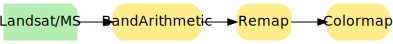

In [17]:
enhanced_ndvi.draw_graph()

### Saving your results

The `save()` method on ImageryLayer class persists this imagery layer to the GIS as an Imagery Layer item.

In [18]:
from arcgis.geocoding import geocode

# get spatial extent of Redlands
area = geocode('Redlands, CA', out_sr=l8_lyr.properties.spatialReference)[0]

savedimg = ndvi_lr.export_image(bbox=area['extent'], size=[1200,450], f='image', save_folder='.', save_file='img.jpg')
savedimg

'./img.jpg'

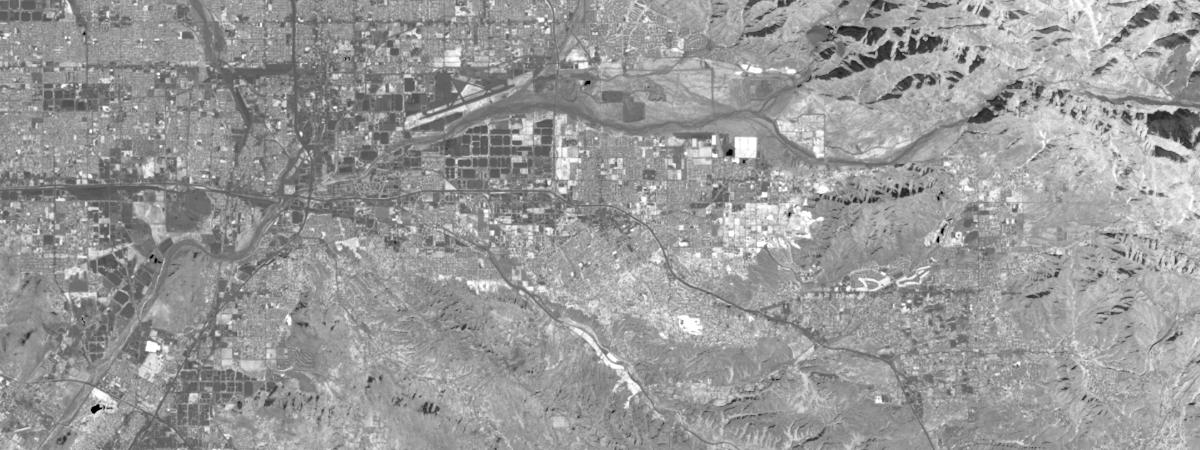

In [19]:
from IPython.display import Image
Image(savedimg)

In [20]:
lyr = enhanced_ndvi.save('Test_viz_layer3', for_viz=True)
lyr

<Item title:"Test_viz_layer3" type:Imagery Layer owner:arcgis_python>